In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from imutils import paths
import numpy as np
import sys
import cv2
import os

sys.path.append("..")

from bodypose.training.metrics import avgMDE_2D, avgMDE_2D_RAW, Accuracy
from bodypose.training.metrics import RegressionLoss2D, AuxiliaryLoss
from bodypose.training.preprocessing import load_TFRecords_dataset  
from bodypose.training.preprocessing import augmentations
from bodypose.training.architecture import MoveNet
from bodypose.demo.graphics import draw_keypoints
from bodypose.training.architecture.custom_layers import get_max_mask

import config as cfg

In [2]:
INPUT_SHAPE = (224, 224, 3)
STRIDES = (32, 16, 8, 4)
NUM_KPTS = len(cfg.MPII_KEYPOINT_DICT)

GRID_SIZE = INPUT_SHAPE[0] // STRIDES[-1]

In [3]:
filePaths = list(paths.list_files("../dataset/tfrecords/mpii/validation/"))
print(f"[INFO] Found {len(filePaths)} TFRecords.")

ds = load_TFRecords_dataset(
    filePaths=filePaths, 
    batch_size = 10,
    target_size = INPUT_SHAPE[:2],
    grid_dim = GRID_SIZE,
    augmentations = [],
    roi_thresh = 0.9
    )

[INFO] Found 10 TFRecords.


2022-11-05 10:43:49.176705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
model = MoveNet(
    input_shape = INPUT_SHAPE, 
    strides = STRIDES, 
    num_joints = NUM_KPTS, 
    alpha = .5, 
    use_depthwise = True,
    debug=True
    )

img = (np.random.uniform(
    0, 255, (1,) + INPUT_SHAPE
    ).astype("uint8") / 255).astype(np.float32)

%timeit model(img)

157 ms ± 23.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
model.summary()

Model: "move_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 backbone (Functional)       [(None, 7, 7, 1280),      706224    
                              (None, 14, 14, 288),               
                              (None, 28, 28, 96),                
                              (None, 56, 56, 96)]                
                                                                 
 FPN (Functional)            (None, 56, 56, 64)        113920    
                                                                 
 head (Functional)           [(None, 56, 56, 1),       48337     
                              (None, 56, 56, 32),                
                              (None, 56, 56, 16),                
                              (None, 56, 56, 32)]                
                                                                 
 post_processing (Functional  [(None, 16, 5),          0  

In [6]:
for img, (y1, y2) in ds.take(1):
    kpts, heatmaps, w_heatmaps = model(img)
    kpts = kpts[0].numpy()
    heatmaps  = heatmaps[0].numpy()

print(kpts)

[[ 0.34909242  0.20750104  0.15073398  0.15361679  0.16133589]
 [ 0.3884048   0.3507545   0.8839785   0.33194485  0.85977435]
 [ 0.38047296  0.61787415  0.04378369  0.61421263  0.03978258]
 [ 0.2912029   0.43845037  0.65019834  0.4005026   0.6296759 ]
 [ 0.32509315  0.45671052  0.50763625  0.4569108   0.5006016 ]
 [ 0.33155972  0.77622145  0.7604024   0.72011     0.73606706]
 [ 0.34723917  0.02655785  0.42094827 -0.0029915   0.40955913]
 [ 0.34706298  0.50663733  0.9756728   0.4997888   1.0392693 ]
 [ 0.3873251   0.42024738  0.51010644  0.4056362   0.49927557]
 [ 0.43287596  0.63571304  0.4005379   0.640017    0.3987177 ]
 [ 0.32363418  0.39955094  0.6710389   0.4262786   0.6733534 ]
 [ 0.3394722   0.5466835   0.36530074  0.52725035  0.38434753]
 [ 0.41292715  0.332826    0.9009053   0.32677412  0.8901359 ]
 [ 0.20904239  0.77825916  0.7069565   0.751892    0.70594084]
 [ 0.31777087  0.17290209  0.3116577   0.18292755  0.29801375]
 [ 0.43984455  0.24138615  0.8114839   0.24494943  0.79

1/1 [==============================] - 1s 1s/step


Text(0.5, 1.0, 'Weighted Keypointsmap')

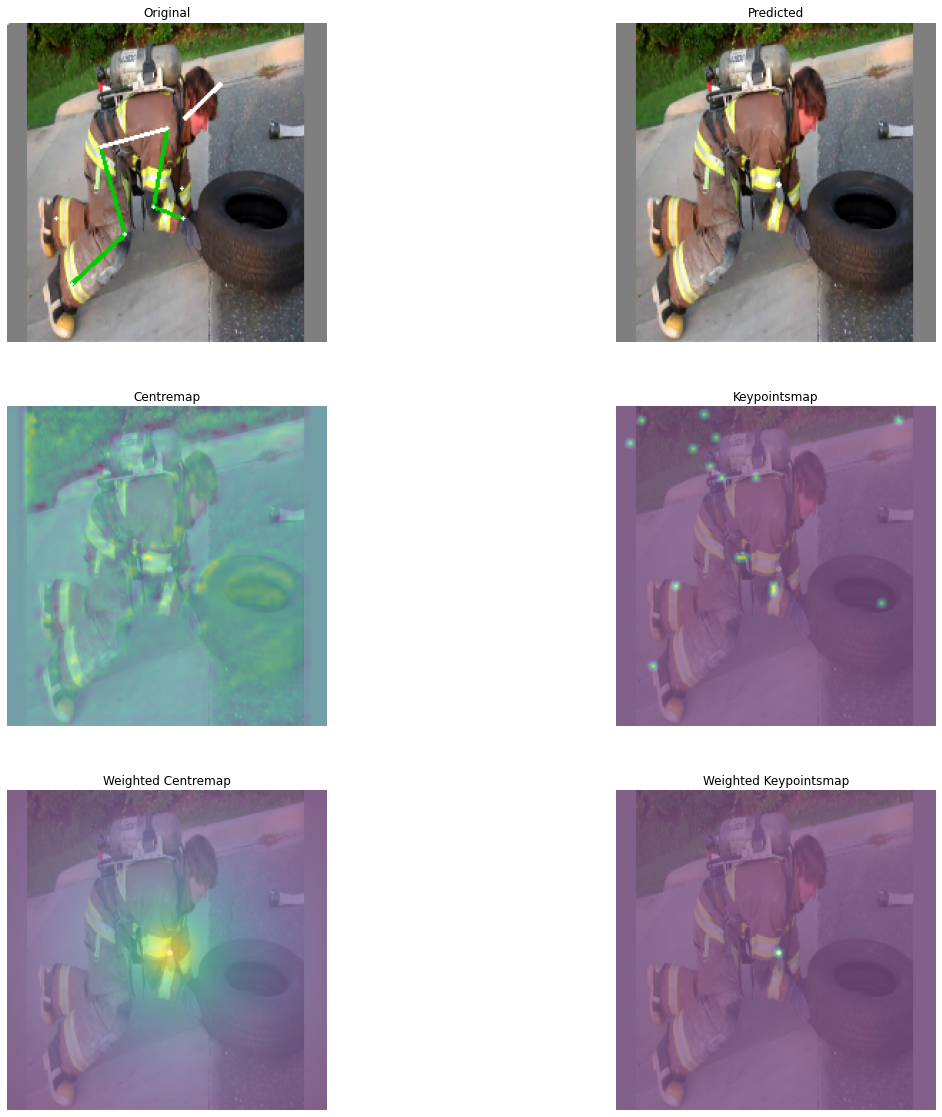

In [6]:

i=1

pred_img = ((img[i].numpy() + 1) * 127.5).astype('uint8').copy()
true_img = ((img[i].numpy() + 1) * 127.5).astype('uint8').copy()

preds, heatmaps, w_heatmaps = model.predict(img[i:i+1])
preds = preds[0, :, :3]
preds = preds[:, [1,2,0]]

# Heatmaps
kptsmask = get_max_mask(heatmaps.reshape(-1, 56, 56, NUM_KPTS+1))
kptsmap = kptsmask[0, :, :, 1:].numpy().sum(axis=-1)
kptsmap = cv2.resize(kptsmap, INPUT_SHAPE[:2])

centremap = heatmaps[0, :, 0].reshape(56, 56)
centremap = cv2.resize(centremap, INPUT_SHAPE[:2])

# Weighted heatmaps
w_kptsmask = get_max_mask(w_heatmaps.reshape(-1, 56, 56, NUM_KPTS+1))
w_kptsmap = w_kptsmask[0, :, :, 1:].numpy().sum(axis=-1)
w_kptsmap = cv2.resize(w_kptsmap, INPUT_SHAPE[:2])

w_centremap = w_heatmaps[0, :, 0].reshape(56, 56)
w_centremap = cv2.resize(w_centremap, INPUT_SHAPE[:2])


labels = y1[i, :, :3].numpy()
labels = labels[:, [1,2,0]]

pred_img = draw_keypoints(pred_img, preds, .5, cfg.MPII_KEYPOINT_DICT)
true_img = draw_keypoints(true_img, labels, .5, cfg.MPII_KEYPOINT_DICT)

fig, axs = plt.subplots(3, 2)
fig.set_figheight(20)
fig.set_figwidth(20)

axs[0,0].imshow(true_img)
axs[0,0].axis('off')
axs[0,0].set_title("Original")

axs[0,1].imshow(pred_img)
axs[0,1].axis('off')
axs[0,1].set_title("Predicted")

axs[1,0].imshow(pred_img, alpha=.5)
axs[1,0].imshow(centremap,  alpha=.5)
axs[1,0].axis('off')
axs[1,0].set_title("Centremap")

axs[1,1].imshow(pred_img, alpha=.5)
axs[1,1].imshow(kptsmap,  alpha=.5)
axs[1,1].axis('off')
axs[1,1].set_title("Keypointsmap")

axs[2,0].imshow(pred_img, alpha=.5)
axs[2,0].imshow(w_centremap,  alpha=.5)
axs[2,0].axis('off')
axs[2,0].set_title("Weighted Centremap")

axs[2,1].imshow(pred_img, alpha=.5)
axs[2,1].imshow(w_kptsmap,  alpha=.5)
axs[2,1].axis('off')
axs[2,1].set_title("Weighted Keypointsmap")

In [8]:
x = tf.ones_like(y1)

In [9]:
Accuracy(y1, x)

<tf.Tensor: shape=(), dtype=float32, numpy=0.675>